In [ ]:
#the libraries you'll need:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from ast import literal_eval
import ee
!pip install geemap
import geemap

     |████████████████████████████████| 1.9 MB 5.2 MB/s 
     |████████████████████████████████| 216 kB 70.8 MB/s 
     |████████████████████████████████| 1.6 MB 27.3 MB/s 
     |████████████████████████████████| 1.3 MB 40.4 MB/s 
     |████████████████████████████████| 130 kB 70.1 MB/s 
     |████████████████████████████████| 3.3 MB 20.7 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
     |████████████████████████████████| 219 kB 55.6 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 8.6 MB 18.8 MB/s 
     |████████████████████████████████| 95 kB 3.7 MB/s 
     |████████████████████████████████| 98 kB 7.7 MB/s 
     |████████████████████████████████| 1.2 MB 47.4 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 396 kB 69.9 MB/s 
     |████████████████████████████████| 428 kB 73.1 MB/s 
     |████████████████████████████████| 58 kB 5.1 MB/s 
     |█████████████████████

In [ ]:
#you need to get the dataset with satellite imgaery and slum categories

URL = 'https://drive.google.com/file/d/1f4Wpz7xFrPoAUJ2pCwWyEywvxl3PTw4g/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]

#don't remember exactly why the convertors are used, maybe readin into the right format
df = pd.read_csv(path, converters={'B11': eval, 'B12': eval, 'B2': eval, 'B3': eval, 'B4': eval, 'B5': eval, 'B6': eval, 'B7': eval, 'B8': eval, 'B8A': eval})

In [ ]:
# we need to append all the satellite band columns together into a single column
images_unconcat = df[["B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A"]] # this is just the input data columns
images_unconcat['combined']= images_unconcat.values.tolist()
data = images_unconcat["combined"].to_numpy().tolist() 
data = np.array(data) # a sinle list of the input data, I think there was a reason why we go to array to list back to array, having to do with how it interpreted things as a numpy array of lists first, as opposed to just a plin numpy array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print("previous data shape", data.shape)
data = data.reshape(1319, 17, 17, 10) # we want to reshape so bands are last - common for CNNs

previous data shape (1319, 10, 17, 17)


In [ ]:
y = df["DN"].to_numpy() 
# this is the output data, three categories, 1: slum, 2: not-slum, 3: vegetation

In [ ]:
(unique, counts) = np.unique(y, return_counts=True)
print(unique, counts) # this gives up the counts of slums and not-slums in out data set

[1 2 3] [705 119 495]


In [ ]:
y[y > 1] = 2
y = y-1 # so now we only have two categories: 0: slum, 1: not-slum
(unique, counts) = np.unique(y, return_counts=True)
print(unique, counts) # this gives up the counts of slums and not-slums in out data set

[0 1] [705 614]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.10) # splitting our data into training and testing

In [ ]:
#we build the network
model = models.Sequential()
model.add(layers.Conv2D(17, (3, 3), padding="same", activation='relu', input_shape=(17, 17, 10)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(30, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.build((17, 17, 10))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 17, 17, 17)        1547      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 17)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1088)              0         
                                                                 
 dense (Dense)               (None, 30)                32670     
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 34,248
Trainable params: 34,248
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#we train the network
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
38/38 [==============================] - 2s 17ms/step - loss: 0.6947 - accuracy: 0.4853 - val_loss: 0.6901 - val_accuracy: 0.5379
Epoch 2/100
38/38 [==============================] - 0s 12ms/step - loss: 0.6886 - accuracy: 0.5341 - val_loss: 0.6877 - val_accuracy: 0.5379
Epoch 3/100
38/38 [==============================] - 0s 13ms/step - loss: 0.6873 - accuracy: 0.5341 - val_loss: 0.6865 - val_accuracy: 0.5379
Epoch 4/100
38/38 [==============================] - 1s 14ms/step - loss: 0.6863 - accuracy: 0.5341 - val_loss: 0.6854 - val_accuracy: 0.5379
Epoch 5/100
38/38 [==============================] - 0s 13ms/step - loss: 0.6851 - accuracy: 0.5341 - val_loss: 0.6845 - val_accuracy: 0.5379
Epoch 6/100
38/38 [==============================] - 0s 12ms/step - loss: 0.6844 - accuracy: 0.5341 - val_loss: 0.6832 - val_accuracy: 0.5379
Epoch 7/100
38/38 [==============================] - 1s 14ms/step - loss: 0.6826 - accuracy: 0.5341 - val_loss: 0.6819 - val_accuracy: 0.5379
Epoch 

In [ ]:
#we can see what the model spit out on parts of out test dataset
print(model(X_test[:10]), y_test[:10])

tf.Tensor(
[[0.23891366]
 [0.18089   ]
 [0.99178576]
 [0.9987796 ]
 [0.8222181 ]
 [0.063348  ]
 [0.41840282]
 [0.00810885]
 [0.9184938 ]
 [0.03656152]], shape=(10, 1), dtype=float32) [0 0 1 1 1 0 0 0 1 0]


In [ ]:
# access to Earth Engine account

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=1aMrylTJPZYfQgli8ZMBCUF97jV-fTOl3V53aQIuD9E&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWj2ALLiN8Pa7pZIVU_6LTz8ytTf7yuaVgdV3qN1FSAot7s-yyEalhc

Successfully saved authorization token.


In [ ]:
center_lat = 51.51
center_long = -0.12
size = 0.005

In [ ]:
def study_area(center_lat= 51.51, center_long= -0.12, size = 0.005):
  #creates a polygon in earth engine which we can use to point to the area we want to study
  study_area = ee.Geometry.Polygon([ 
                            [center_long + size, center_lat + size], 
                            [center_long + size, center_lat - size],
                            [center_long - size, center_lat - size],
                            [center_long - size, center_lat + size]])
  return study_area

study_area = study_area(center_lat, center_long, size)

In [ ]:
# view the study area:
Map = geemap.Map(center=[center_lat ,center_long], basemap = 'HYBRID', zoom=17)
Map.addLayer(study_area, {'color': 'red'}, 'study area')
Map

Map(center=[51.51, -0.12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [ ]:
# downloading Sentinel 2 imagery for study area

dataset = ee.ImageCollection('COPERNICUS/S2_SR').filterDate('2020-01-01', '2021-01-30').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',1)) # this is the original sent_2_data for many dates
sent2_data = dataset.mean() # we get a pic thats the average of the dates

# we look at some of the bands of the sentinel data
Map = geemap.Map(center=[center_lat,center_long], basemap = 'HYBRID', zoom=17)
Map.addLayer(sent2_data, {"bands" : ['B4', 'B3', 'B2'], "max" : 3000, "gamma" : 2}, 'Sentinel Imagery Study Area')
Map.addLayer(study_area, {'color': 'red'}, 'study area')
Map

Map(center=[51.51, -0.12], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [ ]:
def get_sat_data_for_region(study_area):
  #this gets the sentinel satellite data in our study area
  kernel_size = 8
  bands_landuse = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
  image_neighborhood = sent2_data.select(bands_landuse).neighborhoodToArray(ee.Kernel.rectangle(kernel_size, kernel_size, 'pixels'))
  train_db = image_neighborhood.sampleRegions(collection = study_area, scale = 30)
  train_db_local = train_db.getInfo()
  spectral_keys = list(train_db_local["features"][0]["properties"].keys())
  rows_list = []
  for i in range(len(train_db_local["features"])):
    row_i = train_db_local["features"][i]["properties"]
    rows_list.append(row_i)
  df = pd.DataFrame(data=rows_list)
  df['combined']= df.values.tolist()
  data_res_region = df["combined"].to_numpy()
  data_list_res_region = data_res_region.tolist()
  data_res_region = np.array(data_list_res_region)
  data_res_region = data_res_region.reshape(data_res_region.shape[0], 17, 17, 10)
  return data_res_region

satellite_data_of_region = get_sat_data_for_region(study_area) # can take a moment to get and process

In [ ]:
#now you can apply the model to the data you get:
model(satellite_data_of_region)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [ ]:
satellite_data_of_region.shape

(1369, 17, 17, 10)

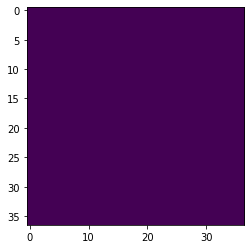

In [ ]:
#and draw a square picture to get an idea
pic_data = model(satellite_data_of_region).numpy()[:,0].reshape(37, 37)
from matplotlib import pyplot as plt
plt.imshow(pic_data, interpolation='nearest')
plt.show()